In [19]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import matplotlib.pyplot as plt

In [20]:
normal_df = pd.read_csv('../data/alfa-romeo-normal-data.csv')
normal_df.head()

,Engine_RPM,Injector_Flow_Rate,Injector_Pulse_Width,Injector_Timing,Fuel_Pressure
0,2882.026173,265.486191,2.398941,12.000000,2.871683
1,2200.078604,213.127190,2.083384,11.174033,2.757739
2,2489.368992,200.000000,3.000000,9.205295,3.039940
3,3120.446600,221.887259,2.595325,10.867099,2.905526
4,2933.778995,200.000000,2.411095,11.000594,2.413166


In [21]:
# Standardizing the data
scaler = StandardScaler()
scaled_normal_df = scaler.fit_transform(normal_df)

# Train Isolation Forest on normal data
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(scaled_normal_df)

IsolationForest(random_state=42)

In [22]:
# Save the scaler and model to disk
dump(scaler, '../models/scaler.joblib')
dump(iso_forest, '../models/iforest.joblib')

['../models/iforest.joblib']

In [23]:
# Creating the DataFrame
faulty_df = pd.read_csv('../data/alfa-romeo-faulty-data.csv')
faulty_df.head()

,Datetime,Engine_RPM,Injector_Flow_Rate,Injector_Pulse_Width,Injector_Timing,Fuel_Pressure
0,2023-12-21 07:40:00.000000000,1620.848713,161.136964,3.151253,15.287632,0.213920
1,2023-12-21 07:40:01.381381381,1558.698311,159.143517,3.799856,15.144757,0.166382
2,2023-12-21 07:40:02.762762762,1744.061603,165.123738,3.000000,17.000000,0.180830
3,2023-12-21 07:40:04.144144144,2120.866600,154.058988,5.000000,16.387548,0.176245
4,2023-12-21 07:40:05.525525525,1504.876745,169.612763,4.866270,15.139102,0.184998


In [24]:
# Load the scaler and model from disk
scaler = load('../models/scaler.joblib')
model = load('../models/iforest.joblib')

In [25]:
# Convert the 'Datetime' column to datetime
faulty_df['Datetime'] = pd.to_datetime(faulty_df['Datetime'])

# Store the 'Datetime' column in a separate variable before dropping it
datetime_col = faulty_df['Datetime']
faulty_df = faulty_df.drop(columns=['Datetime'])

scaled_faulty_df = scaler.fit_transform(faulty_df)

# Apply the model to the new data to predict anomalies
anomaly_scores = iso_forest.decision_function(scaled_faulty_df)
anomaly_labels = iso_forest.predict(scaled_faulty_df)

# Add a column to the faulty data to show anomalies
faulty_df['Anomaly_Score'] = anomaly_scores
faulty_df['Anomaly_Score_IFR_Norm'] = faulty_df['Anomaly_Score'] * 1000
faulty_df['Anomaly_Score_IPW_Norm'] = faulty_df['Anomaly_Score'] * 10
faulty_df['Anomaly_Score_IT_Norm'] = faulty_df['Anomaly_Score'] * 100
faulty_df['Anomaly_Label'] = anomaly_labels

# Add the 'Datetime' column back to the dataframe
faulty_df['Datetime'] = datetime_col

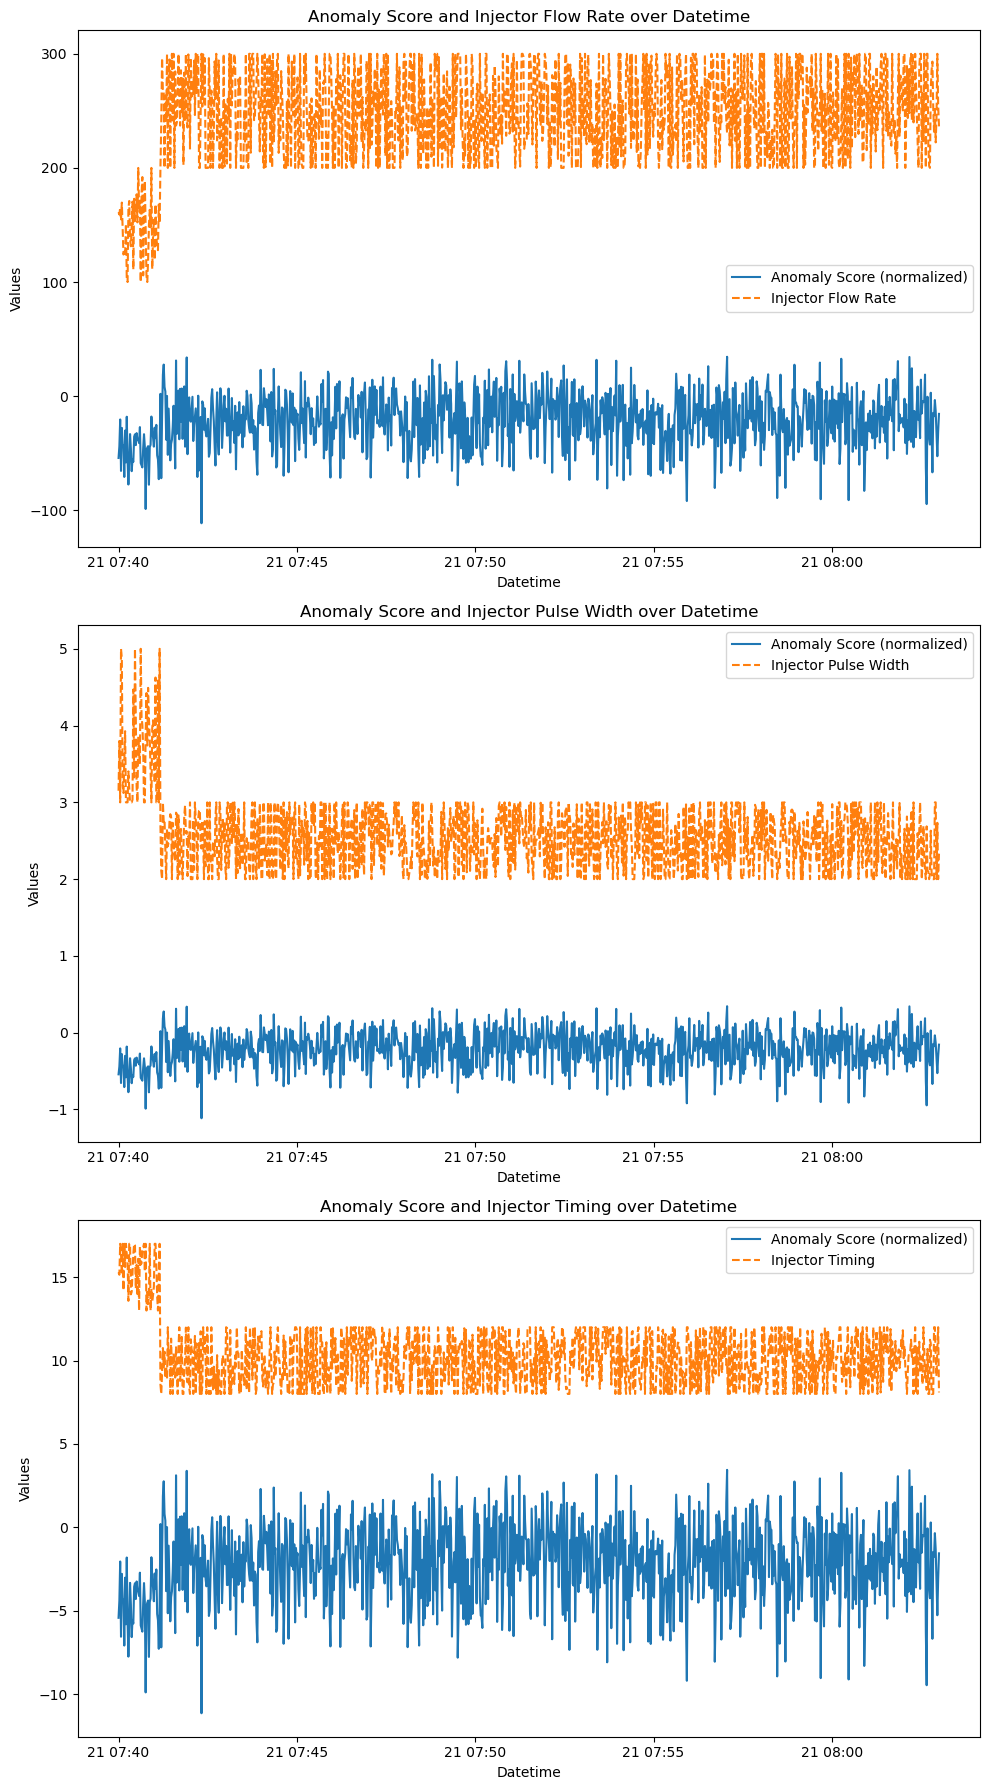

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(10,18))

# Plot for Anomaly Score and Injector Flow Rate
axs[0].plot(faulty_df['Datetime'], faulty_df['Anomaly_Score_IFR_Norm'], label='Anomaly Score (normalized)')
axs[0].plot(faulty_df['Datetime'], faulty_df['Injector_Flow_Rate'], label='Injector Flow Rate', linestyle='--')
axs[0].set_xlabel('Datetime')
axs[0].set_ylabel('Values')
axs[0].set_title('Anomaly Score and Injector Flow Rate over Datetime')
axs[0].legend()

# Plot for Injector Pulse Width
axs[1].plot(faulty_df['Datetime'], faulty_df['Anomaly_Score_IPW_Norm'], label='Anomaly Score (normalized)')
axs[1].plot(faulty_df['Datetime'], faulty_df['Injector_Pulse_Width'], label='Injector Pulse Width', linestyle='--')
axs[1].set_xlabel('Datetime')
axs[1].set_ylabel('Values')
axs[1].set_title('Anomaly Score and Injector Pulse Width over Datetime')
axs[1].legend()

# Plot for Injector Pulse Width
axs[2].plot(faulty_df['Datetime'], faulty_df['Anomaly_Score_IT_Norm'], label='Anomaly Score (normalized)')
axs[2].plot(faulty_df['Datetime'], faulty_df['Injector_Timing'], label='Injector Timing', linestyle='--')
axs[2].set_xlabel('Datetime')
axs[2].set_ylabel('Values')
axs[2].set_title('Anomaly Score and Injector Timing over Datetime')
axs[2].legend()

plt.tight_layout()
plt.show()

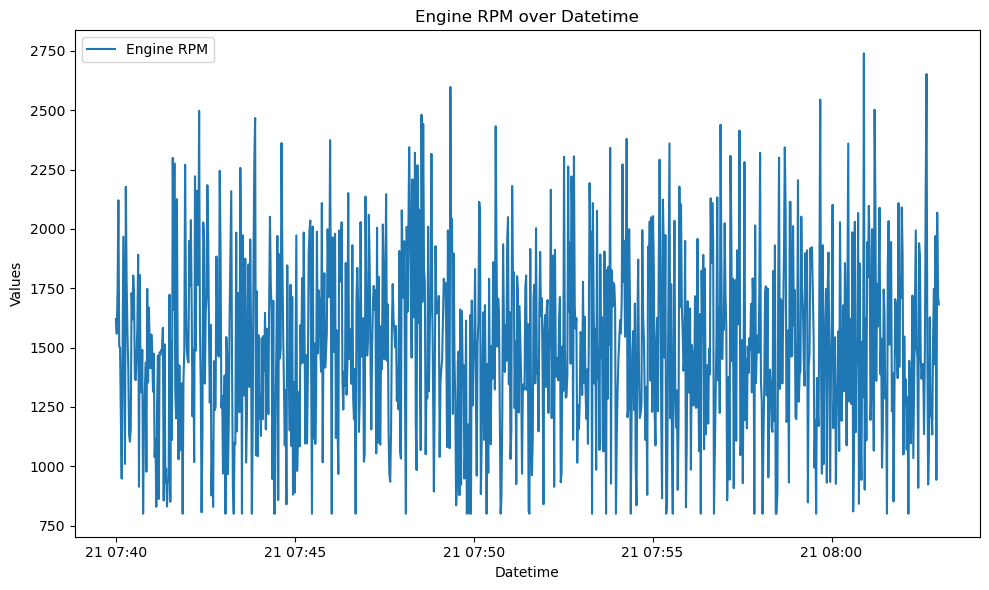

In [27]:
plt.figure(figsize=(10,6))
plt.plot(faulty_df['Datetime'], faulty_df['Engine_RPM'], label='Engine RPM')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.title('Engine RPM over Datetime')
plt.legend()
plt.tight_layout()
plt.show()